In [2]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [3]:
def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / sc.calorie / 1000) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

In [4]:
def safe_frac(invT, dH_fold, Tm, R=1.987e-3, clip_logK=50.0, eps=1e-12):
    """
    invT     : 1/T in K^-1  (your x)
    dH_fold  : kcal/mol
    Tm       : °C (as in your current code)
    R        : kcal/(mol·K)
    """

    invT = np.asarray(invT)

    # Convert Tm to Kelvin
    TmK = Tm + 273.15

    # logK1 = (dH/R) * (1/Tm - 1/T) = (dH/R) * (1/TmK - invT)
    logK1 = (dH_fold / R) * (1.0 / TmK - invT)

    # Clip to avoid huge exponents in the logistic
    logK1 = np.clip(logK1, -clip_logK, clip_logK)

    # Stable logistic: fracf = 1 / (1 + exp(-logK1))
    fracf = 1.0 / (1.0 + np.exp(-logK1))
    fracu = 1.0 - fracf

    # If you ever reintroduce logs, avoid exact 0 or 1
    fracf = np.clip(fracf, eps, 1.0 - eps)
    fracu = np.clip(fracu, eps, 1.0 - eps)

    return fracu, fracf

def melt_fit(x, upper_m, upper_b, lower_m, lower_b, dH_fold, Tm):
    # upper_m: slope of the unfolded state
    # upper_b: y-intercept of the unfolded state
    # lower_m: slope of the folded state
    # lower_b: y-intercept of the folded state
    # dH_fold: energy of the transition state
    # Tm: temperature of the transition state
    
    temp = 1 / x

    R = sc.R / sc.calorie / 1000  # Gas constant in kcal/(mol·K)

    fracu, fracf = safe_frac(x, dH_fold, Tm, R=R)
    basef = lower_m * x + lower_b
    baseu = upper_m * x + upper_b

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

In [5]:
sns_cb12 = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#D4C72F",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#403D99",  # indigo
    "#782AA8",  # deep purple
    "#882233",  # deep maroon
    "#919191",  # gray
]

# Calculate kinetic parameters at a given temp
# Make directory to store
os.makedirs('kinetic_params_per_nt', exist_ok=True)

temp_C = 25.0
conc_DMS = 0.015852692  # in M, 1.5% v/v

# Load ln(kadd) Arrhenius fits
lnkadd_A_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_A_arrhenius_fit.sav')
lnkadd_C_linfit = load_modelresult('../../Figure2_ProbeKinetics/Add_Arrhenius/Arrhenius_fit_results/agg_4U_C_arrhenius_fit.sav')
lnkadd_linfits = {'A': lnkadd_A_linfit,
                  'C': lnkadd_C_linfit}

A18_params = pd.read_csv('../4U_2stateMelt/kinetic_params_per_nt/4U_A18_kinetic_params_25C.csv')
to_fit = {'4U_wt': ['7_A', '8_A', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A'],
          '4U_a8c': ['7_A', '8_C', '9_C', '15_A', '16_A', '22_A', '25_C', '26_A', '29_A', '34_A', '35_A']}

# Calculate kinetic parameters at temp_C
rows = []
for construct, sites in to_fit.items():
    for site in sites:

        # Load 2-state fit result
        fit_result = load_modelresult(f'../4U_2stateMelt/2state_fit_results/{construct}_{site}.sav')
        lnkadd_fit = lnkadd_linfits[site[-1]]

        for temp_C in np.linspace(10, 60, 500):
            # Evaluate ln(kobs) and ln(kadd) at temp_C
            ln_kobs = fit_result.eval(x = 1/(temp_C + 273.15))
            ln_kobs_err = fit_result.eval_uncertainty(x = 1/(temp_C + 273.15))

            # Evaluate ln(kadd) at temp_C
            ln_kadd = lnkadd_fit.eval(x = 1/(temp_C + 273.15)) + np.log(conc_DMS)
            ln_kadd_err = lnkadd_fit.eval_uncertainty(x = 1/(temp_C + 273.15))

            dG, dG_err, KKp1, KKp1_err = calc_dG(ln_kobs, ln_kobs_err, ln_kadd, ln_kadd_err, temp_C)

            rows.append({
                'construct': construct,
                'site': site,
                'temp_C': temp_C,
                'ln_kobs': ln_kobs,
                'ln_kobs_err': ln_kobs_err,
                'ln_kadd': ln_kadd,
                'ln_kadd_err': ln_kadd_err,
                'dG': dG,
                'dG_err': dG_err,
            })

calculated_lnkobs_from_fits = pd.DataFrame(rows)

In [6]:
# Special processing for A18
all_lnkobs_data = pd.read_csv('mean_lnkobs_data/all_lnkobs_by_temp.csv')

# Evaluate ln(kadd) at each temperature
inv_T = 1 / (all_lnkobs_data['temperature'] + 273.15)

ln_kadd = lnkadd_fit.eval(x=inv_T) + np.log(conc_DMS)
ln_kadd_err = lnkadd_fit.eval_uncertainty(x=inv_T)

def _calc_dG_row(row):
    ln_kadd = (lnkadd_fit.eval(x=1 / (row['temperature'] + 273.15)) + np.log(conc_DMS))
    ln_kadd_err = lnkadd_fit.eval_uncertainty(x=1 / (row['temperature'] + 273.15))

    dG, dG_err, _, _ = calc_dG(
        row['ln_kobs_mean'],
        row['ln_kobs_err'],
        ln_kadd,
        ln_kadd_err,
        row['temperature']
    )
    return pd.Series({'dG': dG, 'dG_err': dG_err})

all_lnkobs_data[['dG', 'dG_err']] = all_lnkobs_data.apply(_calc_dG_row, axis=1)
# filter to under 61C for plot
all_lnkobs_data = all_lnkobs_data[all_lnkobs_data['temperature'] <= 60.0].copy()

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_2405/614654883.py:15: RuntimeWarning: invalid value encountered in log
  dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


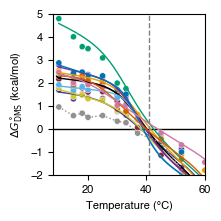

In [7]:
# Filter to just WT
calculated_lnkobs_from_fits_WT = calculated_lnkobs_from_fits[calculated_lnkobs_from_fits['construct'] == '4U_wt']
lnkobs_data_WT = all_lnkobs_data[all_lnkobs_data['construct'] == '4U_wt']

# Split out A18 data (since no fits)
lnkobs_data_WT_A18 = lnkobs_data_WT[lnkobs_data_WT['site'] == '18_A']

fig, ax = plt.subplots(figsize = (2.25, 2.25))

# match color by site
site_order = sorted(lnkobs_data_WT['site'].unique())
site_order = [s for s in site_order if s != '18_A'] + ['18_A']
# match color by site
site_palette = {'15_A': '#000000',
                '16_A': '#E69F00',
                '22_A': '#56B4E9',
                '25_C': '#009E73',
                '26_A': '#782AA8',
                '29_A': '#0072B2',
                '34_A': '#D55E00',
                '35_A': '#CC79A7',
                '7_A': '#403D99',
                '8_A': '#D4C72F',
                '9_C': '#882233',
                '18_A': '#919191'}

# horizontal line at 0
ax.hlines(0, xmin = 0, xmax = 60, colors="black", linewidth=1, zorder=-10)

sns.lineplot(
    data=calculated_lnkobs_from_fits_WT,
    x='temp_C',
    y='dG',
    hue='site',
    palette=site_palette,
    linewidth=1,
    ax=ax,
)

sns.scatterplot(
    data=lnkobs_data_WT,
    x='temperature',
    y='dG',
    hue='site',
    palette=site_palette,
    s=20,
    ax=ax,
)

sns.lineplot(data = lnkobs_data_WT_A18, 
             x='temperature', 
             y='dG', 
             linestyle = ':', 
             linewidth = 1,
             color = site_palette['18_A'], 
             ax = ax
)

lnkobs_data_WT.to_csv('wt_dG_v_temp.csv')
lnkobs_data_WT_A18.to_csv('wt_A18_dG_v_temp.csv')

# vertical line at 41°C
ax.vlines(41, ymin = -2, ymax = 5, colors="gray", linestyles="dashed", linewidth=1)

# remove legend
ax.legend().remove()
ax.set_xlim(8, 60)
ax.set_ylim(-2, 5)

# set labels
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\Delta G^{\circ}_{\text{DMS}}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('4U_wt_dG_vs_temp.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


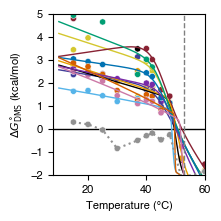

In [10]:
# Filter to just A8C
calculated_lnkobs_from_fits_A8C = calculated_lnkobs_from_fits[calculated_lnkobs_from_fits['construct'] == '4U_a8c']
lnkobs_data_A8C = all_lnkobs_data[all_lnkobs_data['construct'] == '4U_a8c']

# Split out A18 data (since no fits) - to draw connected line
lnkobs_data_A8C_A18 = lnkobs_data_A8C[lnkobs_data_A8C['site'] == '18_A']

fig, ax = plt.subplots(figsize = (2.25, 2.25))
 
# match color by site
site_palette = {'15_A': '#000000',
                '16_A': '#E69F00',
                '22_A': '#56B4E9',
                '25_C': '#009E73',
                '26_A': '#782AA8',
                '29_A': '#0072B2',
                '34_A': '#D55E00',
                '35_A': '#CC79A7',
                '7_A': '#403D99',
                '8_C': '#D4C72F',
                '9_C': '#882233',
                '18_A': '#919191'}

ax.hlines(0, xmin = 0, xmax = 60, colors="black", linewidth=1, zorder=-10)

sns.lineplot(
    data=calculated_lnkobs_from_fits_A8C,
    x='temp_C',
    y='dG',
    hue='site',
    palette=site_palette,
    linewidth=1,
    ax=ax,
)

sns.scatterplot(
    data=lnkobs_data_A8C,
    x='temperature',
    y='dG',
    hue='site',
    palette=site_palette,
    s=20,
    ax=ax,
)

sns.lineplot(data = lnkobs_data_A8C_A18, 
             x='temperature', 
             y='dG', 
             linestyle = ':', 
             color = site_palette['18_A'], 
             ax = ax
)

# vertical line at 41°C
ax.vlines(53, ymin = -2, ymax = 5, colors="gray", linestyles="dashed", linewidth=1)


# remove legend
ax.legend().remove()
ax.set_xlim(8, 60)
ax.set_ylim(-2, 5)

# set labels
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\Delta G^{\circ}_{\text{DMS}}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('4U_a8c_dG_vs_temp.pdf')

lnkobs_data_A8C.to_csv('a8c_dG_v_temp.csv')
lnkobs_data_A8C_A18.to_csv('a8c_A18_dG_v_temp.csv')

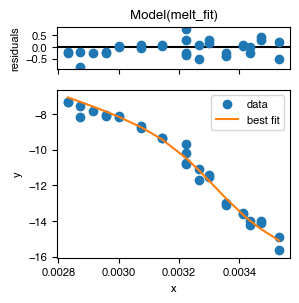

In [9]:
# Visualize a single 2-state fit result

construct = '4U_wt'
site = '35_A'
out = load_modelresult(f'../4U_2stateMelt/2state_fit_results/{construct}_{site}.sav')
out.plot(fig_kws = {'figsize': (3, 3)})
out